# Imports



In [232]:
! pip install ipympl

In [233]:
import copy

from google.colab import output
output.enable_custom_widget_manager()

import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, Layout

In [234]:
%matplotlib ipympl

# implementing a RNN layer



In [235]:
class RNNLayer(nn.Module):
    def __init__(self, input_size, hidden_size, nonlinearity=th.tanh):
        """
        Initialize a single RNN layer.

        Inputs:
        - input_size: Data input feature dimension
        - hidden_size: RNN hidden state size (also the output feature dimension)
        - nonlinearity: Nonlinearity applied to the rnn output
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.Wxh = nn.Parameter(th.randn(input_size, hidden_size))
        self.Whh = nn.Parameter(th.randn(hidden_size, hidden_size))
        self.bh = nn.Parameter(th.zeros(hidden_size))


    def forward(self, x):
        """
        RNN forward pass

        Inputs:
        - x: input tensor (B, seq_len, input_size)

        Returns:
        - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
                 produced for each timestep
        - last_h: hidden state from the last timestep (B, hidden_size)
        """
        h_list = []  # List to store the hidden states [h_1, ... h_T]
        h_list = []
        batch_size, seq_len, _ = x.size()
        last_h = th.zeros(batch_size, self.hidden_size)

        for t in range(seq_len):
          xt = x[:, t, :]
          ht = self.nonlinearity(th.matmul(xt, self.Wxh) + th.matmul(last_h, self.Whh) + self.bh)
          h_list.append(ht)
          last_h = ht

        self.store_h_for_grad(h_list)
        all_h = th.stack(h_list, dim=1)
        return all_h, last_h

    def store_h_for_grad(self, h_list):
        """
        Store input list and allow gradient computation for all list elements
        """
        for h in h_list:
            h.retain_grad()
        self.h_list = h_list

In [236]:
rnn = RNNLayer(1, 1)
# Overwrite initial parameters with fixed values.
# Should give deterministic results even with different implementations.
rnn.load_state_dict({k: v * 0 + .1 for k, v in rnn.state_dict().items()})
data = th.ones((1, 1, 1))
expected_out = th.FloatTensor([[[0.1973753273487091]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_out.shape
assert th.all(th.isclose(all_h, last_h))
print(f'Expected: {expected_out.item()}, got: {last_h.item()}, max error: {th.max(th.abs(expected_out - last_h)).item()}')

rnn = RNNLayer(2, 3, nonlinearity=lambda x: x)  # no nonlinearity

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 18, f'expected 18 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1250, -0.1250, -0.1250],
         [-0.1075, -0.1075, -0.1075],
         [-0.1328, -0.1328, -0.1328],
         [-0.1452, -0.1452, -0.1452]],

        [[ 0.0600,  0.0600,  0.0600],
         [ 0.1520,  0.1520,  0.1520],
         [ 0.2344,  0.2344,  0.2344],
         [-0.0853, -0.0853, -0.0853]]])
expected_last_h = th.FloatTensor([[-0.1452, -0.1452, -0.1452],
        [-0.0853, -0.0853, -0.0853]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

Expected: 0.1973753273487091, got: 0.1973753273487091, max error: 0.0
Max error all_h: 4.999339580535889e-05
Max error last_h: 2.498924732208252e-05


# Implementing a RNN regression model


In [237]:
class RecurrentRegressionModel(nn.Module):
    def __init__(self, recurrent_net, output_dim=1):
        """
        Initialize a simple RNN regression model

        Inputs:
        - recurrent_net: an RNN or LSTM (single or multi layer)
        - output_dim: feature dimension of the output
        """
        super().__init__()
        self.recurrent_net = recurrent_net
        self.output_dim = output_dim
        hidden_size = recurrent_net.hidden_size
        self.linear = nn.Linear(hidden_size, output_dim)


    def forward(self, x):
        """
        Forward pass

        Inputs:
        - x: input tensor (B, seq_len, input_size)

        Returns:
        - out: predictions of shape (B, seq_len, self.output_dim).
        - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
                 produced for each timestep.
        """
        all_h, _ = self.recurrent_net(x)
        out = self.linear(all_h)
        return out, all_h

## Tests

In [238]:
rnn = RecurrentRegressionModel(RNNLayer(2, 3), 4)

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 34, f'expected 34 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_preds = th.FloatTensor([[[-0.0627, -0.0627, -0.0627, -0.0627],
         [-0.0678, -0.0678, -0.0678, -0.0678],
         [-0.0604, -0.0604, -0.0604, -0.0604],
         [-0.0567, -0.0567, -0.0567, -0.0567]],

        [[-0.1180, -0.1180, -0.1180, -0.1180],
         [-0.1453, -0.1453, -0.1453, -0.1453],
         [-0.1692, -0.1692, -0.1692, -0.1692],
         [-0.0748, -0.0748, -0.0748, -0.0748]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
preds, all_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert preds.shape == expected_preds.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_preds - preds)).item()}')

Max error all_h: 4.699826240539551e-05
Max error last_h: 4.3138861656188965e-05


# Dataset and loss function

## Inspect the dataset

In [239]:
def generate_batch(seq_len=10, batch_size=1):
  data = th.randn(size=(batch_size, seq_len, 1))
  sums = th.cumsum(data, dim=1)
  div = (th.arange(seq_len) + 1).unsqueeze(0).unsqueeze(2)
  target = sums / div
  return data, target

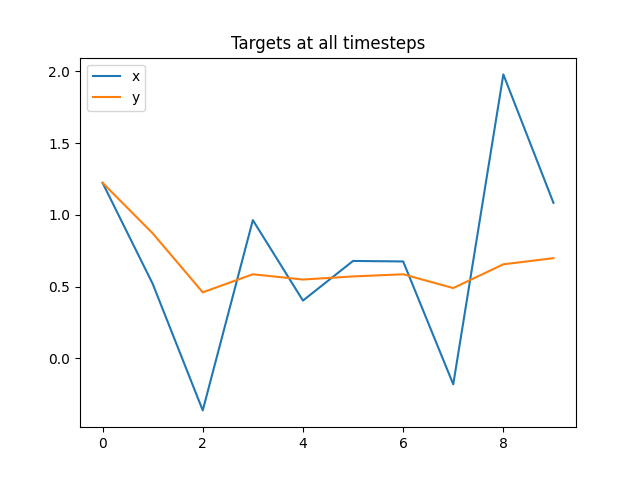

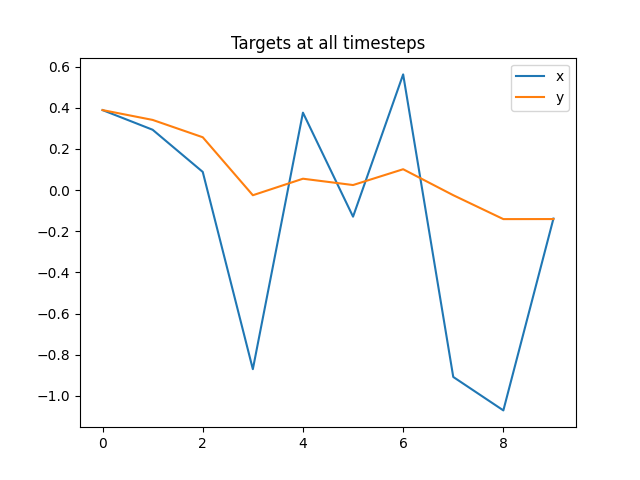

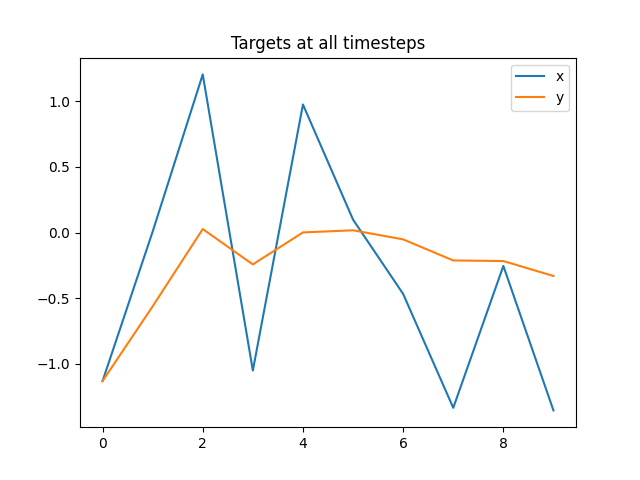

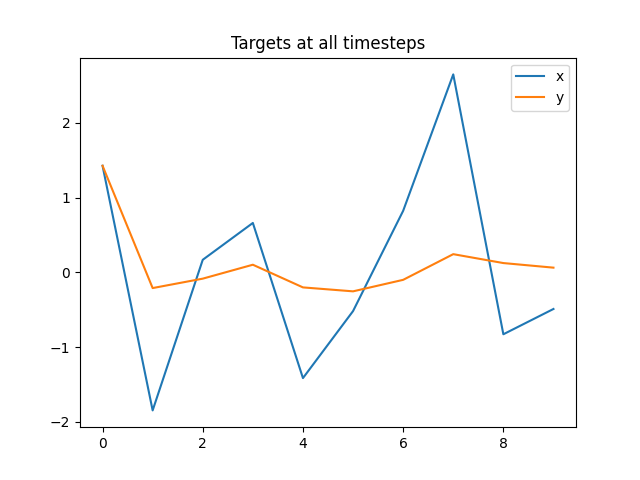

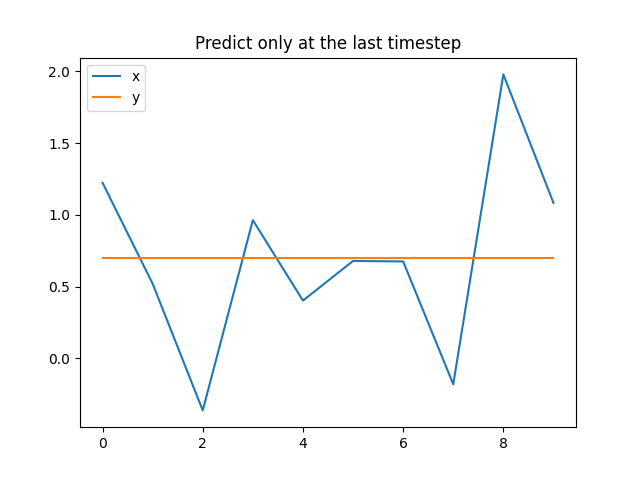

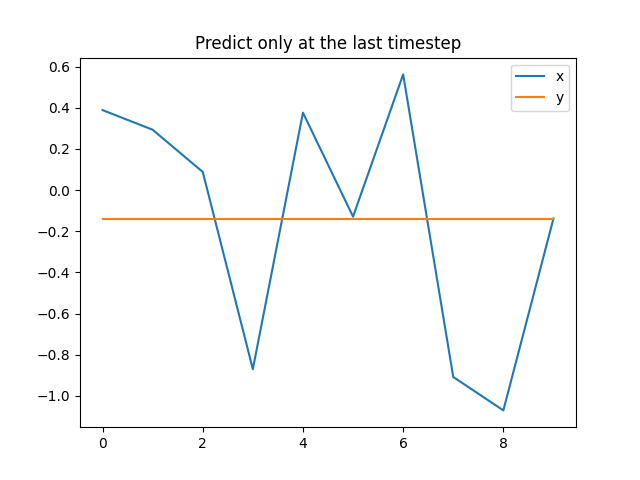

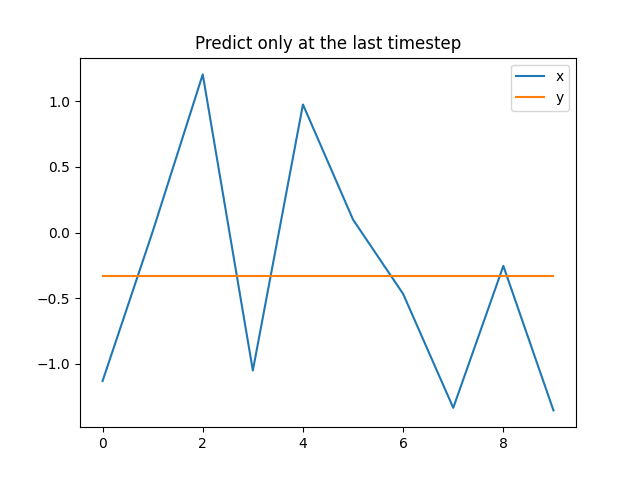

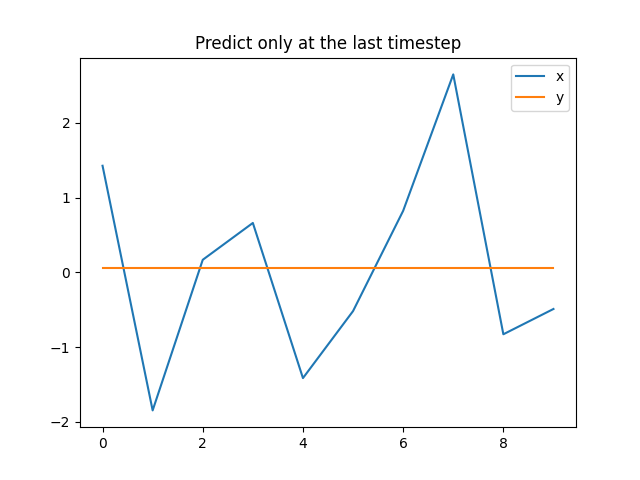

In [240]:
x, y = generate_batch(seq_len=10, batch_size=4)
for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(y[i, :, 0])
  ax1.legend(['x', 'y'])
  plt.title('Targets at all timesteps')
  plt.show()

for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(np.arange(10), [y[i, -1].item()] * 10)
  ax1.legend(['x', 'y'])
  plt.title('Predict only at the last timestep')
  plt.show()

## loss function

In [241]:
def loss_fn(pred, y, last_timestep_only=False):
  """
  Inputs:
  - pred: model predictions of size (batch, seq_len, 1)
  - y: targets of size (batch, seq_len, 1)
  - last_timestep_only: boolean indicating whether to compute loss for all
    timesteps or only the lat

  Returns:
  - loss: scalar MSE loss between pred and true labels
  """
  if last_timestep_only:
    pred_last = pred[:, -1]
    y_last = y[:, -1]
    loss = F.mse_loss(pred_last, y_last)
  else:
    loss = F.mse_loss(pred, y)
  return loss

### Tests
errors should < 1e-4

In [242]:
pred = th.FloatTensor([[.1, .2, .3], [.4, .5, .6]])
y = th.FloatTensor([[-1.1, -1.2, -1.3], [-1.4, -1.5, -1.6]])
loss_all = loss_fn(pred, y, last_timestep_only=False)
loss_last = loss_fn(pred, y, last_timestep_only=True)
assert loss_all.shape == loss_last.shape == th.Size([])
print(f'Max error loss_all: {th.abs(loss_all - th.tensor(3.0067)).item()}')
print(f'Max error loss_last: {th.abs(loss_last - th.tensor(3.7)).item()}')

Max error loss_all: 3.314018249511719e-05
Max error loss_last: 2.384185791015625e-07


# Analyzing RNN Gradients

In [243]:
def biggest_eig_magnitude(matrix):
  """
  Inputs: a square matrix
  Returns: the scalar magnitude of the largest eigenvalue
  """
  h, w = matrix.shape
  assert h == w, f'Matrix has shape {matrix.shape}, but eigenvalues can only be computed for square matrices'
  eigs = th.linalg.eigvals(matrix)
  eig_magnitude = eigs.abs()
  eigs_sorted = sorted([i.item() for i in eig_magnitude], reverse=True)
  first_eig_magnitude = eigs_sorted[0]
  return first_eig_magnitude

class GradientVisualizer:

  def __init__(self, rnn, last_timestep_only):
    """
    Inputs:
    - rnn: rnn module
    - last_timestep_only: boolean indicating whether to compute loss for all
      timesteps or only the lat

    Returns:
    - loss: scalar MSE loss between pred and true labels
    """

    self.rnn = rnn
    self.last_timestep_only = last_timestep_only
    self.model = RecurrentRegressionModel(rnn)
    self.original_weights = copy.deepcopy(rnn.state_dict())

    # Generate a single batch to be used repeatedly
    self.x, self.y = generate_batch(seq_len=10)
    print(f'Data point: x={np.round(self.x[0, :, 0].detach().cpu().numpy(), 2)}, y={np.round(self.y.squeeze().detach().cpu().numpy(), 2)}')

  def plot_visuals(self):
    """ Generate plots which will be updated in realtime."""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('RNN Outputs')
    ax1.set_xlabel('Unroll Timestep')
    ax1.set_ylabel('Hidden State Norm')
    ax1.set_ylim(-1, 5)
    plt_1 = ax1.plot(np.arange(1, 11), np.zeros(10) + 1)  # placeholder vals
    plt_1 = plt_1[0]

    ax2.set_title('Gradients')
    ax2.set_xlabel('Unroll Timestep')
    ax2.set_ylabel('RNN dLoss/d a_t Gradient Magitude')
    ax2.set_ylim( (10**-6,1e5) )
    ax2.set_yscale('log')
    # X-axis labels are reversed since the gradient flow is from later layers to earlier layers
    ax2.set_xticks(np.arange(10), np.arange(10, 0, -1))
    plt_2 = ax2.plot(np.arange(10), np.arange(10) + 1)  # placeholder vals
    plt_2 = plt_2[0]
    self.fig = fig
    self.plots = [plt_1, plt_2]
    return plt_1, plt_2, fig

  # Main update function for interactive plot
  def update_plots(self, weight_val=0, bias_val=0):
    # Scale the original RNN weights by a constant
    w_dict = copy.deepcopy(self.original_weights)
    for k in w_dict.keys():
      if 'weight' in k:
        w_dict[k][:] *= weight_val
      elif 'bias' in k:
        w_dict[k][:] *= bias_val

    self.rnn.load_state_dict(w_dict)

    if isinstance(self.rnn, RNNLayer):
      W = self.rnn.Wxh
      k = min(W.size(0), W.size(1))
      W = W.narrow(0, 0, k).narrow(1, 0, k)
      biggest_eig = biggest_eig_magnitude(W)
      print(f' Biggest eigenvalue magnitude: {biggest_eig:.3}')

    # Run model
    pred, h = self.model(self.x)
    loss = loss_fn(pred, self.y, self.last_timestep_only)
    n_steps = len(h[0])

    plt_1, plt_2 = self.plots

    # Plot the hidden state magnitude
    max_h = th.linalg.norm(h[0], dim=-1).detach().cpu().numpy()
    print('Max H', ' '.join([f'{num:.3}' for num in max_h]))
    plt_1.set_data(np.arange(1, n_steps + 1), np.array(max_h))
    # Compute the gradient for the loss wrt the stored hidden states
    # Gradients are plotted backward since we go from later layers to earlier
    grads = [th.linalg.norm(num).item() for num in th.autograd.grad(loss, self.rnn.h_list)][::-1]
    print('gradients d Loss/d h_t', ' '.join([f'{num:.3}' for num in grads]))
    # Add 1e-6 since it throws an error for gradients near 0
    plt_2.set_data(np.arange(n_steps), np.array(grads) + 1e-6)
    self.fig.canvas.draw_idle()

  def create_visualization(self):
    # Include sliders for relevant quantities
    self.plot_visuals()
    ip = interactive(self.update_plots,
                    weight_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="weight_scale", layout=Layout(width='100%')),
                    bias_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="bias_scale", layout=Layout(width='100%')),
                    )
    return ip

Adjust the sliders rescale the weight and bias parameters in the RNN. Observe the effect on exploding and vanishing gradients.

We can vary:
*   nonlinearity
*   last_target_only



Data point: x=[-0.64  0.59  1.03  0.14 -0.03  0.19  0.52  0.07  0.46 -0.51], y=[-0.64 -0.02  0.33  0.28  0.22  0.21  0.26  0.23  0.26  0.18]


<ipython-input-243-ec14bedffc49>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)


<bound method GradientVisualizer.update_plots of <__main__.GradientVisualizer object at 0x79ef0ab453c0>>

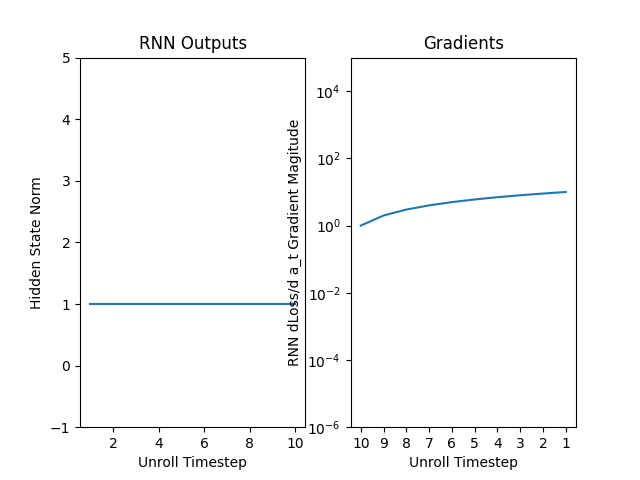

In [244]:
hidden_size = 16
nonlinearity = (
    lambda x: x
)  # options include lambda x: x (no nonlinearity), nn.functional.relu, and th.tanh
last_target_only = True
rnn = RNNLayer(1, hidden_size, nonlinearity=nonlinearity)
gv = GradientVisualizer(rnn, last_target_only)
gv.create_visualization()
gv.update_plots
# -5 - 5


# RNN for Last Name Classification


## Download Data

In [245]:
import os

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

## Library imports

Before starting, make sure you have all these libraries.

In [246]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [247]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implement the Neural Network

The main objective of this task is to predict the probability of a given class given a last name, represented as

$$ \Pr ( y | x_1, x_2, x_3, ..., x_i),$$

where $y$ is the category label and each $x_i$ is a character in the last name. Building a basic character-level NLP model has the advantage of understanding how the preprocessing works at a granular level. The character-level network reads words as a sequence of characters, producing a prediction and "hidden state" at each step by feeding its previous hidden state into the next step. The final prediction corresponds to the class to which the word belongs.

All models in PyTorch inherit from the nn.Module subclass. In this assignment, you will **implement a custom model named `RecurrentClassifier`** that runs either [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and define its forward function. The implementation of LSTMs is *optional*.

The forward pass of the model can be visualized with the following diagram:

```
[Embedding] -> [RNN Stack] -> [Extract Last Position] -> [Classifier]
```

- **Embedding:** This component maps each input word (integer) to a vector of real numbers.
    - Input: `[batch_size, seq_len]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **RNN Stack:** This component consists of one or more RNN layers, which process the input sequence of vectors from the Embedding component.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **Extract Last Position:** The RNN Stack component returns a sequence of vectors for each input example. However, for classification purposes, we only need a single vector that captures the full information of the input example. Since the RNN is left-to-right by default, the output state vector at the last position contains the full information of the input example. Therefore, for the $i$-th input example, we extract the output state vector at the last *non-pad* position, which is indicated by `last_pos[i]`.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, rnn_size]`
- **Classifier:** This component is a fully-connected layer that maps the output vectors extracted in the previous step to logits (scores before softmax), which can be used to make predictions about the language of origin for each input example.
    - Input: `[batch_size, rnn_size]`
    - Output: `[batch_size, n_categories]`



- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
- https://pytorch.org/docs/stable/generated/torch.gather.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [248]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = "lstm",
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type
        self.embedding = nn.Embedding(vocab_size, rnn_size)

        if self.model_type == 'lstm':
            self.lstm = nn.LSTM(rnn_size, rnn_size, num_layers, dropout=dropout, batch_first=True)
        elif self.model_type == 'rnn':
            self.rnn = nn.RNN(rnn_size, rnn_size, num_layers, nonlinearity='tanh', dropout=dropout, batch_first=True)

        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(rnn_size, n_categories)


    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)
        if self.model_type == "lstm":
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        out = rnn_out[torch.arange(x.size(0)), last_pos]

        out = self.drop(out)
        logits = self.output(out)
        return logits

In [249]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [250]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0',
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

In [251]:
x = torch.arange(20).view(5, 4) % 11
last_pos = torch.tensor([2, 3, 1, 2, 3])
seed = 1025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logits = model(x, last_pos)

print(logits.shape)
assert logits.shape == torch.Size([5, 17])
print(logits.view(-1)[40:45])
assert torch.allclose(
    logits.view(-1)[40:45],
    torch.tensor(
        [
            -0.27393126487731934,
            0.28421181440353394,
            0.2342953234910965,
            0.23580458760261536,
            0.06812290847301483,
        ],
        dtype=torch.float,
    ),
)

model.zero_grad()
logits.sum().backward()
assert torch.allclose(
    model.rnn.weight_hh_l0.grad.view(-1)[40:45],
    torch.tensor(
        [
            -0.9424352645874023,
            -0.488606333732605,
            0.6905138492584229,
            -0.0017577260732650757,
            1.1024625301361084,
        ],
        dtype=torch.float,
    ),
)

torch.Size([5, 17])
tensor([-0.2739,  0.2842,  0.2343,  0.2358,  0.0681], grad_fn=<SliceBackward0>)


## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [252]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [253]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [254]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [255]:
def letterToIndex(letter):
    return all_letters.index(letter)

assert letterToIndex("a") == 0
assert letterToIndex("'") == 56

In [256]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character
vocab_size = 58 # number of characters used in total

In [257]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [258]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [259]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [260]:
len(train_data)

16059

In [261]:
train_data[0]

(array([27,  0,  1,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 8,
 3)

In [262]:
len(test_data)

4015

In [263]:
test_data[0]

(array([26, 13, 19,  0, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 7,
 4)

# Train the model

In [264]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [265]:
build_batch(train_data, [1, 2, 3])

(array([[33,  0, 17, 19, 20, 10, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [33,  0, 13,  0, 13,  8,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [33, 14, 20, 19, 20, 12, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57]]),
 array([3, 7, 5]),
 array([7, 6, 5]))

In [266]:
criterion = nn.CrossEntropyLoss()

batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())


hidden_size = 64
num_layers = 2
dropout = 0.2
optimizer_class = optim.Adam
lr = 1e-3
batch_size = 128

epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cpu for training


In [267]:

lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [268]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [269]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [270]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 119  Loss: 1.2319292902946473: 100%|██████████| 126/126 [00:02<00:00, 47.48it/s]


Epoch: 0  Train Accuracy: 57.189115137928894
Epoch: 0  Eval Accuracy: 66.32627646326277


Epoch: 1  Iteration: 119  Loss: 1.0381017744541168: 100%|██████████| 126/126 [00:02<00:00, 53.37it/s]


Epoch: 1  Train Accuracy: 69.32561180646366
Epoch: 1  Eval Accuracy: 71.25778331257784


Epoch: 2  Iteration: 119  Loss: 0.9190264582633972: 100%|██████████| 126/126 [00:05<00:00, 22.41it/s]


Epoch: 2  Train Accuracy: 72.83766112460303
Epoch: 2  Eval Accuracy: 73.22540473225405


Epoch: 3  Iteration: 119  Loss: 0.8542476773262024: 100%|██████████| 126/126 [00:04<00:00, 28.22it/s]


Epoch: 3  Train Accuracy: 74.94239990036739
Epoch: 3  Eval Accuracy: 74.32129514321295


Epoch: 4  Iteration: 119  Loss: 0.7888642728328705: 100%|██████████| 126/126 [00:04<00:00, 26.02it/s]


Epoch: 4  Train Accuracy: 76.42443489631982
Epoch: 4  Eval Accuracy: 75.66625155666252


Epoch: 5  Iteration: 119  Loss: 0.7275810360908508: 100%|██████████| 126/126 [00:06<00:00, 19.64it/s]


Epoch: 5  Train Accuracy: 77.2214957344791
Epoch: 5  Eval Accuracy: 75.54171855541718


Epoch: 6  Iteration: 119  Loss: 0.7060836970806121: 100%|██████████| 126/126 [00:02<00:00, 59.54it/s]


Epoch: 6  Train Accuracy: 78.42954106731428
Epoch: 6  Eval Accuracy: 76.11457036114571


Epoch: 7  Iteration: 119  Loss: 0.7165661692619324: 100%|██████████| 126/126 [00:02<00:00, 58.80it/s]


Epoch: 7  Train Accuracy: 78.8218444485958
Epoch: 7  Eval Accuracy: 77.43462017434621


Epoch: 8  Iteration: 119  Loss: 0.6789190769195557: 100%|██████████| 126/126 [00:02<00:00, 46.16it/s]


Epoch: 8  Train Accuracy: 79.73721900491935
Epoch: 8  Eval Accuracy: 77.6587795765878


Epoch: 9  Iteration: 119  Loss: 0.6905741930007935: 100%|██████████| 126/126 [00:02<00:00, 47.34it/s]


Epoch: 9  Train Accuracy: 79.85553272308363
Epoch: 9  Eval Accuracy: 77.8082191780822


Epoch: 10  Iteration: 119  Loss: 0.6168676853179932: 100%|██████████| 126/126 [00:02<00:00, 58.56it/s]


Epoch: 10  Train Accuracy: 80.35369574693318
Epoch: 10  Eval Accuracy: 79.25280199252802


Epoch: 11  Iteration: 119  Loss: 0.6299219071865082: 100%|██████████| 126/126 [00:02<00:00, 56.09it/s]


Epoch: 11  Train Accuracy: 81.08225916931315
Epoch: 11  Eval Accuracy: 78.58032378580324


Epoch: 12  Iteration: 119  Loss: 0.6592837452888489: 100%|██████████| 126/126 [00:02<00:00, 59.45it/s]


Epoch: 12  Train Accuracy: 81.5119247773834
Epoch: 12  Eval Accuracy: 79.15317559153175


Epoch: 13  Iteration: 119  Loss: 0.5655709773302078: 100%|██████████| 126/126 [00:02<00:00, 47.34it/s]


Epoch: 13  Train Accuracy: 81.84818481848185
Epoch: 13  Eval Accuracy: 78.9788293897883


Epoch: 14  Iteration: 119  Loss: 0.5451451241970062: 100%|██████████| 126/126 [00:02<00:00, 51.93it/s]


Epoch: 14  Train Accuracy: 82.39616414471635
Epoch: 14  Eval Accuracy: 79.17808219178082


Epoch: 15  Iteration: 119  Loss: 0.577058482170105: 100%|██████████| 126/126 [00:02<00:00, 59.40it/s]


Epoch: 15  Train Accuracy: 82.377483031322
Epoch: 15  Eval Accuracy: 79.80074719800747


Epoch: 16  Iteration: 119  Loss: 0.5483637243509293: 100%|██████████| 126/126 [00:02<00:00, 54.74it/s]


Epoch: 16  Train Accuracy: 82.83205679058472
Epoch: 16  Eval Accuracy: 79.15317559153175


Epoch: 17  Iteration: 119  Loss: 0.5768996894359588: 100%|██████████| 126/126 [00:02<00:00, 60.45it/s]


Epoch: 17  Train Accuracy: 83.15586275608693
Epoch: 17  Eval Accuracy: 79.7758405977584


Epoch: 18  Iteration: 119  Loss: 0.5141980618238449: 100%|██████████| 126/126 [00:02<00:00, 48.73it/s]


Epoch: 18  Train Accuracy: 83.37380907902111
Epoch: 18  Eval Accuracy: 79.90037359900374


Epoch: 19  Iteration: 119  Loss: 0.5186820179224014: 100%|██████████| 126/126 [00:02<00:00, 49.42it/s]


Epoch: 19  Train Accuracy: 83.74120430911015
Epoch: 19  Eval Accuracy: 80.19925280199253


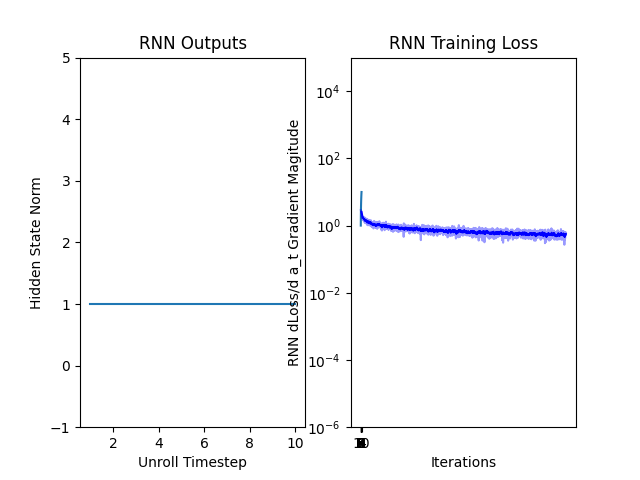

In [271]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

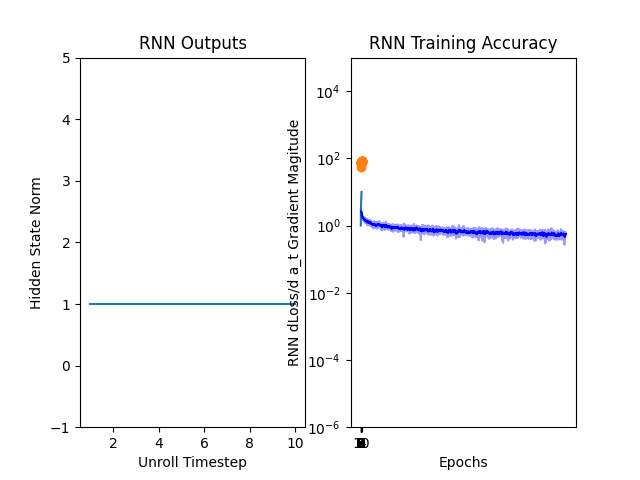

In [272]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

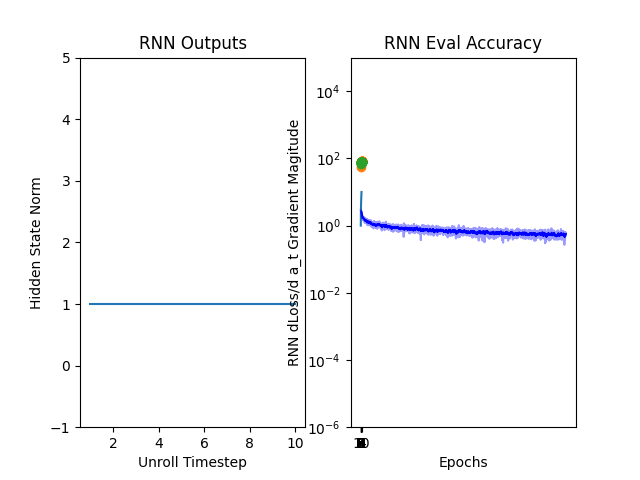

In [273]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [274]:

train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 119  Loss: 1.3939586758613587: 100%|██████████| 126/126 [00:05<00:00, 22.57it/s]


Epoch: 0  Train Accuracy: 51.653278535400716
Epoch: 0  Eval Accuracy: 62.39103362391034


Epoch: 1  Iteration: 119  Loss: 1.1560352385044097: 100%|██████████| 126/126 [00:07<00:00, 17.55it/s]


Epoch: 1  Train Accuracy: 65.86337879070926
Epoch: 1  Eval Accuracy: 69.29016189290161


Epoch: 2  Iteration: 119  Loss: 0.9728941917419434: 100%|██████████| 126/126 [00:05<00:00, 23.52it/s]


Epoch: 2  Train Accuracy: 71.5175291114017
Epoch: 2  Eval Accuracy: 72.9016189290162


Epoch: 3  Iteration: 119  Loss: 0.8813534855842591: 100%|██████████| 126/126 [00:05<00:00, 21.11it/s]


Epoch: 3  Train Accuracy: 74.69954542624073
Epoch: 3  Eval Accuracy: 75.19302615193027


Epoch: 4  Iteration: 119  Loss: 0.7769156277179718: 100%|██████████| 126/126 [00:05<00:00, 24.56it/s]


Epoch: 4  Train Accuracy: 76.84787346659195
Epoch: 4  Eval Accuracy: 76.36363636363637


Epoch: 5  Iteration: 119  Loss: 0.6925318539142609: 100%|██████████| 126/126 [00:06<00:00, 21.00it/s]


Epoch: 5  Train Accuracy: 78.67862257923906
Epoch: 5  Eval Accuracy: 77.55915317559153


Epoch: 6  Iteration: 119  Loss: 0.6873192429542542: 100%|██████████| 126/126 [00:05<00:00, 24.61it/s]


Epoch: 6  Train Accuracy: 79.83062457189115
Epoch: 6  Eval Accuracy: 78.3810709838107


Epoch: 7  Iteration: 119  Loss: 0.6472717463970185: 100%|██████████| 126/126 [00:05<00:00, 21.07it/s]


Epoch: 7  Train Accuracy: 80.63391244784856
Epoch: 7  Eval Accuracy: 78.70485678704857


Epoch: 8  Iteration: 119  Loss: 0.614602980017662: 100%|██████████| 126/126 [00:05<00:00, 21.79it/s]


Epoch: 8  Train Accuracy: 81.46833551279656
Epoch: 8  Eval Accuracy: 78.50560398505604


Epoch: 9  Iteration: 119  Loss: 0.6364577919244766: 100%|██████████| 126/126 [00:06<00:00, 20.62it/s]


Epoch: 9  Train Accuracy: 82.17199078398406
Epoch: 9  Eval Accuracy: 79.9252801992528


Epoch: 10  Iteration: 119  Loss: 0.5426036834716796: 100%|██████████| 126/126 [00:05<00:00, 24.80it/s]


Epoch: 10  Train Accuracy: 82.88187309296967
Epoch: 10  Eval Accuracy: 79.80074719800747


Epoch: 11  Iteration: 119  Loss: 0.5785349488258362: 100%|██████████| 126/126 [00:05<00:00, 22.64it/s]


Epoch: 11  Train Accuracy: 83.44230649480042
Epoch: 11  Eval Accuracy: 79.85056039850559


Epoch: 12  Iteration: 119  Loss: 0.5763614177703857: 100%|██████████| 126/126 [00:05<00:00, 24.47it/s]


Epoch: 12  Train Accuracy: 83.79724764929323
Epoch: 12  Eval Accuracy: 80.64757160647572


Epoch: 13  Iteration: 119  Loss: 0.47666879296302794: 100%|██████████| 126/126 [00:05<00:00, 23.55it/s]


Epoch: 13  Train Accuracy: 84.46354069369201
Epoch: 13  Eval Accuracy: 81.56911581569116


Epoch: 14  Iteration: 119  Loss: 0.470404651761055: 100%|██████████| 126/126 [00:05<00:00, 23.04it/s]


Epoch: 14  Train Accuracy: 84.73753035680926
Epoch: 14  Eval Accuracy: 81.07098381070983


Epoch: 15  Iteration: 119  Loss: 0.46841973066329956: 100%|██████████| 126/126 [00:05<00:00, 25.16it/s]


Epoch: 15  Train Accuracy: 85.35400709882309
Epoch: 15  Eval Accuracy: 81.0958904109589


Epoch: 16  Iteration: 119  Loss: 0.46864489614963534: 100%|██████████| 126/126 [00:05<00:00, 21.37it/s]


Epoch: 16  Train Accuracy: 85.9642568030388
Epoch: 16  Eval Accuracy: 81.66874221668742


Epoch: 17  Iteration: 119  Loss: 0.4720343142747879: 100%|██████████| 126/126 [00:05<00:00, 24.45it/s]


Epoch: 17  Train Accuracy: 86.56827946945637
Epoch: 17  Eval Accuracy: 81.86799501867995


Epoch: 18  Iteration: 119  Loss: 0.3727245211601257: 100%|██████████| 126/126 [00:07<00:00, 17.93it/s]


Epoch: 18  Train Accuracy: 86.73018245220749
Epoch: 18  Eval Accuracy: 82.14196762141968


Epoch: 19  Iteration: 119  Loss: 0.43020752668380735: 100%|██████████| 126/126 [00:05<00:00, 24.88it/s]


Epoch: 19  Train Accuracy: 86.93567469954543
Epoch: 19  Eval Accuracy: 81.51930261519303


{'history': {'train_losses': [2.8866055011749268,
   2.868417739868164,
   2.8442537784576416,
   2.82735538482666,
   2.809516429901123,
   2.7848963737487793,
   2.761254072189331,
   2.732151746749878,
   2.7002904415130615,
   2.6612441539764404,
   2.6056227684020996,
   2.5876777172088623,
   2.5108249187469482,
   2.445115327835083,
   2.47650146484375,
   2.2593331336975098,
   2.2296040058135986,
   2.1143736839294434,
   2.142526149749756,
   1.8735239505767822,
   1.8026371002197266,
   1.7871723175048828,
   1.82438325881958,
   1.9547092914581299,
   1.8576769828796387,
   1.9928464889526367,
   1.7945581674575806,
   1.674186110496521,
   1.8962429761886597,
   1.9092516899108887,
   1.99251389503479,
   1.6255102157592773,
   1.8305903673171997,
   1.6910178661346436,
   1.783676028251648,
   1.60282301902771,
   1.7661893367767334,
   1.7285304069519043,
   1.8607499599456787,
   1.8371515274047852,
   1.8124182224273682,
   1.7912862300872803,
   1.684043526649475,
   

## Own Name

 **predict the origin of your own last name**.


In [275]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [276]:
model = rnn_model
model.eval()
model.cpu()
############################################################################
# TODO: Enter your last name
############################################################################
name = "xxx"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Lo
[37 14 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Russian
